In [1]:
import torch
import pickle

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

import math

/home/timsey/anaconda3/envs/c2st/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open("./dihedral.pkl", "rb") as f:
    dihedral_dict = pickle.load(f)

In [3]:
ind1 = dihedral_dict[0]["1"]
ind2 = dihedral_dict[0]["2"]
ind3 = dihedral_dict[0]["3"]
ind4 = dihedral_dict[0]["4"]
coords = dihedral_dict[0]["coords"]  # or just dihedral_dict[1]

In [4]:
# coords == dihedral_dict[1]

In [5]:
# Literal copy of calc_dihedrals
a = coords[:, ind1]
b = coords[:, ind2]
c = coords[:, ind3]
d = coords[:, ind4]

b0 = a - b
b1_un = c - b
b1 = b1_un / torch.norm(b1_un, dim=2, keepdim=True)
b2 = d - c

b1_on_b0 = torch.sum(b0 * b1, dim=2, keepdim=True) * b1
v = b0 - b1_on_b0
b1_on_b2 = torch.sum(b2 * b1, dim=2, keepdim=True) * b1
w = b2 - b1_on_b2
x = torch.sum(v * w, dim=2)
b1xv = torch.cross(b1, v, dim=2)
y = torch.sum(b1xv * w, dim=2)

angle = torch.atan2(y, x)
rtrn = -1 * angle

In [6]:
dih_index = 8

# Batch size = 1, so take 0th element of first dim
# Look at a single dihedral, so take 0th element of second dim
a = a.numpy()[0, dih_index, :]
b = b.numpy()[0, dih_index, :]
c = c.numpy()[0, dih_index, :]
d = d.numpy()[0, dih_index, :]

b0 = b0.numpy()[0, dih_index, :]
b1_un = b1_un.numpy()[0, dih_index, :]
b1 = b1.numpy()[0, dih_index, :]
b2 = b2.numpy()[0, dih_index, :]

b1_on_b0 = b1_on_b0.numpy()[0, dih_index, :]
v = v.numpy()[0, dih_index, :]
b1_on_b2 = b1_on_b2.numpy()[0, dih_index, :]
w = w.numpy()[0, dih_index, :]
x = x.numpy()[0, dih_index]
b1xv = b1xv.numpy()[0, dih_index, :]
y = y.numpy()[0, dih_index]

angle = angle.numpy()[0, dih_index]
rtrn = rtrn.numpy()[0, dih_index]

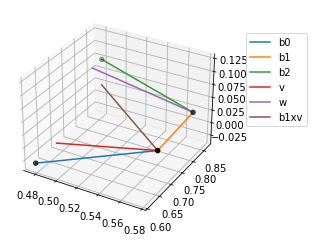

In [7]:
# Atom locations in xyz
xs = [point[0] for point in [a, b, c, d]]  
ys = [point[1] for point in [a, b, c, d]]
zs = [point[2] for point in [a, b, c, d]]

# Vectors
b0_vec = np.stack((b, a))
b1_vec = np.stack((b, c))
b2_vec = np.stack((c, d))
v_vec = np.stack((b, b + v))
w_vec = np.stack((c, c + w))
b1xv_vec = np.stack((b, b + b1xv))

# vecs = [b0_vec, b1_vec, b2_vec]
# labels = ["b0", "b1", "b2"]

vecs = [b0_vec, b1_vec, b2_vec, v_vec, w_vec, b1xv_vec]
labels = ["b0", "b1", "b2", "v", "w", "b1xv"]

# Setup 3D plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plot atom locations
ax.scatter(xs, ys, zs, c="k")

# Plot vectors
for vec, label in zip(vecs, labels):
    ax.plot(vec[:, 0], vec[:, 1], vec[:, 2], label=label)
    
plt.legend(bbox_to_anchor=(1.4, 0.9))

In [8]:
# v is in the plane with b0 and b1.
# w int he plane with b1 and b2.
# The dihedral angle is the angle between the planes going through abc and bcd: e.g., the angle between 
#  the planes of v and w. We cannot directly use these vectors though, since they have different origin points.
#  v and w have the same magnitude though (why?).

In [9]:
dih_ind = 0

ind1[dih_ind, :], ind2[dih_ind, :], ind3[dih_ind, :], ind4[dih_ind, :]

(tensor([0, 1, 2]),
 tensor([12, 13, 14]),
 tensor([3, 4, 5]),
 tensor([ 9, 10, 11]))

### Issue with our usecase: 

We cannot do z-matrix computation in batches, because every item in the batch has a different z-matrix (different atom order). That is, the indices that correspond to a particular atom's coordinates are different each time.

Let's build one!

-----------------

Single water molecule,
Index order = OHH, Topological order = HOH,
n_bond = 2,
n_angle = 1,
n_dih = 0.

Bonds (HOH topologically sorted):
ind1 = [[3, 4, 5], [0, 1, 2]], HO,
ind2 = [[0, 1, 2], [6, 7, 8]], OH.

Angles (idem):
ind1 = [[3, 4, 5]], H,
ind2 = [[0, 1, 2]], O,
ind3 = [[6, 7, 8]], H.

That works, but note how the inds for bonds and angles are very different, and need to be set up separately. Given an X configuration, we first determine the oxygen distances, then probably do a topological order of HOH - HOH by distance. Note that we cannot do an OHH topological order, because the O is the center angle atom.

From X --> Z, this procedure gives the same indices for different configurations, because we have defined an order.
From Z --> X, the flow just outputs (internal) positions, so the molecules need to be reordered according to bond distance to solute O (shortest first). This means that the indices change: e.g. [9, 10, 11] corresponds to the second oxygen atom in the ordered representation, but the flow can just decide on a different order. Wait, does this even work at all then? What grounds the flow; just training?

-----------------

Two water molecules,
Index order = OHH OHH, Topological order = HOH HOH,
n_bond = 2 + 1 + 2 (first molecule, oxygen-oxygen, second molecule)
n_angle = 1 + 1 + 1 (first molecule, oxygen-oxygen w.r.t. azimuth, second molecule),
n_dih = 1 + hydrogens (O1H1H1 to O2H1H1, what to do about hydrogens???)

Simplified indices (OHH OHH = 0, 1, 2, 3, 4, 5):

Bonds: 5,
ind1 = [1, 0, 0, 4, 3], HOOHO,
ind2 = [0, 2, 3, 3, 5], OHOOH.

Angles: 3,
ind1 = [1, 1, 4], HHH,
ind2 = [0, 0, 3], OOO,
ind3 = [2, 3, 5], HOH.

Dihedrals: 1 + 2???,
ind1 = [0, 0, 0], OOO,
ind2 = [1, 1, 1], HHH,
ind3 = [2, 2, 2], HHH,
ind4 = [3, 4, 5], OHH (e.g., dihedrals w.r.t. OHH plane of solute molecule: very hard to reconstruct Z --> X though).

Hmm...

-----------------



# Post Ferry meeting

In [10]:
atoms_per_solute_mol = 3
atoms_per_solvent_mol = 3

num_solvent_mol = 2
num_atoms = atoms_per_solute_mol + num_solvent_mol * atoms_per_solvent_mol

batch_size = 5
dims = 3

x = torch.randn(batch_size, num_atoms, dims)

jac = x.new_zeros(x.shape[0])

In [11]:
x, jac

(tensor([[[ 0.3760,  0.5246,  0.7546],
          [ 0.4845, -0.9311, -0.0757],
          [ 0.1424,  0.5358, -0.3182],
          [ 0.8028, -1.2055,  0.8198],
          [-0.8154,  0.2003,  0.8395],
          [ 1.2119, -0.0860,  1.6828],
          [-0.6134,  0.4623,  1.2622],
          [-2.1685, -0.0192, -0.4346],
          [ 1.1341, -0.8133,  0.1532]],
 
         [[-1.2881, -0.3093, -0.0975],
          [-0.2847, -0.1256, -0.4817],
          [ 1.8825, -0.9490,  0.8126],
          [-0.2594, -0.7653,  1.2097],
          [-0.9177,  1.3622, -0.8109],
          [ 0.6793,  0.5986, -0.2483],
          [ 1.9833, -1.1316, -0.1293],
          [ 1.9427,  0.5753, -0.2260],
          [-1.7842,  0.3951, -1.2082]],
 
         [[-0.2170, -1.1693, -0.5315],
          [-0.3891,  0.1262,  0.1899],
          [-1.3746,  0.5230,  1.2195],
          [ 0.0641, -1.5454,  0.3998],
          [-0.1550,  1.0831, -1.2694],
          [ 0.0479, -0.8718,  0.3831],
          [ 0.2990, -1.1125, -0.3574],
          [ 0.2630,

In [12]:
# Center coordinates: put anchor atom at origin (e.g., the solute oxygen).
x_centered = x - x[:, 0:1, :]

## First ordering the O

In [13]:
# Reference coordinates: e.g., the oxygen atoms
ref_coords = x_centered[:, atoms_per_solute_mol::atoms_per_solvent_mol, :]  # n_batch x num_atoms

# Distances to anchor at origin
ref_dists = torch.norm(ref_coords, dim=2)

# Order reference atoms by distance to origin
ref_permute = torch.argsort(ref_dists, dim=1) * atoms_per_solvent_mol

In [14]:
# Start building full permutation tensor.
#  First step is to permute reference atoms (e.g., oxygens) together with their hydrogens.
#  Then we can start permuting the remaining atoms (e.g., hydrogens) within the molecules, if necessary.
full_permute = torch.zeros(x.shape[:2])

# Solute molecule is fixed; reflect this in permutation tensor.
num_hydrogen = atoms_per_solvent_mol - 1
for j in range(1, num_hydrogen + 1, 1):
    full_permute[:, j] = j

# Inefficient way to build full permutation tensor
for full_perm, ref_perm in zip(full_permute, ref_permute):
    for i, ref_num in enumerate(ref_perm):
        # ref_permute skips solute molecule, so index this back in
        ind = atoms_per_solute_mol + i * atoms_per_solvent_mol  # index in permutation tensor
        atom_num = atoms_per_solute_mol + ref_num  # atom number that should be at this index
        full_perm[ind] = atom_num
        for j in range(1, num_hydrogen + 1, 1):
            full_perm[ind + j] = atom_num + j
            
full_permute   

tensor([[0., 1., 2., 6., 7., 8., 3., 4., 5.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8.],
        [0., 1., 2., 6., 7., 8., 3., 4., 5.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8.]])

### Jacobian determinant of permutation?

The Jacobian of a permutation is the permutation matrix itself. The determinant of this is -1**parity.

In JAX: "The parity of a permutation is related to the determinant of its cycle matrix, and the jacobian of a sort happens to be equivalent to that cycle matrix, so you could (ab)use JAX's automatic differentiation of the sort operator to compute the parities very concisely:"

> def compute_parity(p):
>   return jnp.linalg.det(jax.jacobian(jnp.sort)(p.astype(float))).astype(int)

In [15]:
def perm_parity(lst):
    """
    Given a permutation of the digits 0..N in order as a list, 
    returns its parity (or sign): +1 for even parity; -1 for odd.
    """
    parity = 1
    for i in range(0, len(lst) - 1):
        if lst[i] != i:
            parity *= -1
            mn = min(range(i, len(lst)), key=lst.__getitem__)
            lst[i], lst[mn] = lst[mn], lst[i]
    return parity

# Clone because perm_parity sorts in place.
reference_parities = torch.tensor([perm_parity(perm) for perm in full_permute.clone()])
reference_parities

# Cannot yet to jac * parities here, because jac = 0 (solution: set it to 1 to start if necessary).

tensor([-1,  1, -1,  1,  1])

In [16]:
# Flatten along the batch and atoms dimension to do efficient permutation, rather than a for loop per row.
b = x_centered.shape[0]
n = x_centered.shape[1]
flat_x = x_centered.reshape(b * n, -1)
flat_permute = (full_permute + (torch.arange(0, b) * n).unsqueeze(-1)).flatten().unsqueeze(-1).long()

x_ordered = flat_x[flat_permute].reshape(b, n, flat_x.shape[-1])

x_ordered

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.0848e-01, -1.4557e+00, -8.3031e-01],
         [-2.3357e-01,  1.1199e-02, -1.0728e+00],
         [-9.8937e-01, -6.2304e-02,  5.0753e-01],
         [-2.5445e+00, -5.4378e-01, -1.1893e+00],
         [ 7.5810e-01, -1.3379e+00, -6.0140e-01],
         [ 4.2674e-01, -1.7302e+00,  6.5152e-02],
         [-1.1914e+00, -3.2430e-01,  8.4889e-02],
         [ 8.3586e-01, -6.1060e-01,  9.2820e-01]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.0034e+00,  1.8371e-01, -3.8426e-01],
         [ 3.1706e+00, -6.3970e-01,  9.1003e-01],
         [ 1.0287e+00, -4.5605e-01,  1.3072e+00],
         [ 3.7040e-01,  1.6714e+00, -7.1347e-01],
         [ 1.9674e+00,  9.0788e-01, -1.5088e-01],
         [ 3.2714e+00, -8.2236e-01, -3.1799e-02],
         [ 3.2308e+00,  8.8453e-01, -1.2859e-01],
         [-4.9610e-01,  7.0435e-01, -1.1108e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.7213e-01,  1.2955e+00,  7.2137e-0

## Now ordering the H

### First: alignment with z-axis

In [17]:
def unit_vector(vector):
    """" 
    Returns the unit vector of the vector.  
    """
    return vector / torch.norm(vector, dim=-1, keepdim=True)

def get_angle_and_normal(atom1, atom2, atom3, to_yz_plane=False):
    """" 
    Returns the angle between three atoms in radian, and the axis of rotation.
    
    atom2 is the atom located at vertex where we want to know the angle.
    
    When trying to align axes: atom1 = alignment axis, atom3 = axis to align. This ensures
    that the normal (axis of rotation) has the correct orientation w.r.t. the rotation angle.
    """
    v1 = atom2 - atom1
    v2 = atom2 - atom3
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)

    # atom3 x atom 1, e.g.: H x z^
    cross = torch.cross(v2_u, v1_u, dim=-1)  # normal vector
    dot = torch.sum(v1_u * v2_u, dim=-1)
    rads = torch.arccos(torch.clip(dot, -1.0, 1.0))
    
    # arccos finds the angle between the actual vectors, which means we don't need any tricks to align
    #  the rotation angle and the rotation axis (normal), as both use the same convention.
    # However, we need to fix the rotation axis orientation, so that we know how to reconstruct X from the angle 
    #  information in Z. So we pick the convention that the rotation is the normal with x > 0. 
    # This means that we sometimes flip the convention, so we need to adjust the angle appropriately.
    #  That is, when we find a normal with x < 0, we negate it, and adjust the angle as: rad = 2pi - rad.

    # Note that this can mess up if we are rotating vectors into the yz-plane, since the rotation axis has x=0 there.
    #  If so, we want to use the z > 0 vector as the normal.
    if to_yz_plane:
        if not torch.isclose(cross[:, 0], cross.new_zeros(cross.shape[0])).any():
            raise ValueError("Convention is to rotate normal with x!=0 if possible, but `to_yz_plane` was True.")
        sign = torch.sign(cross[:, 2])  # Flip direction if z < 0
    else:
        if torch.isclose(cross[:, 0], cross.new_zeros(cross.shape[0])).any():
            raise ValueError("Found rotation around axis with x=0. Set `to_yz_plane` to True.")
        sign = torch.sign(cross[:, 0])  # Flip direction if x < 0

    cross = sign.unsqueeze(-1) * cross  
    # Adjust angles:
    #  This evaluates to: 2pi - rads if sign = -1, else: 0 + rads
    rads = 2 * math.pi * (1 - sign) / 2 + sign * rads

    return rads, cross

#### TODO: Do we actually also want to order the first two hydrogen based on angle before deciding which one is the axis aligned one?

In [18]:
# Duplicate axis n_batch times for vectorised operations
alignment_axis = x_ordered.new_zeros(x_ordered.shape[0], 3)
alignment_axis[:, 2] = 1

solute_atom = x_ordered[:, 0, :]  # e.g., first oxygen = [0, 0, 0]
atom_to_align = x_ordered[:, 1, :]  # e.g., first hydrogen; will become [0, 0, r]

# E.g., how far to rotate first hydrogen (=atom_to_align) to align it with the azimuth (= alignment_axis)
# The rotation should happen along the 
rotation_rad, normal_axis = get_angle_and_normal(alignment_axis, solute_atom, atom_to_align)

atom_to_align, rotation_rad, normal_axis

(tensor([[ 0.1085, -1.4557, -0.8303],
         [ 1.0034,  0.1837, -0.3843],
         [-0.1721,  1.2955,  0.7214],
         [ 0.6530,  0.0192,  0.1414],
         [-1.3967, -0.9669, -0.8866]]),
 tensor([4.1952, 1.9311, 1.0664, 1.3576, 4.2313]),
 tensor([[ 0.8668,  0.0646,  0.0000],
         [ 0.1685, -0.9205,  0.0000],
         [ 0.8678,  0.1153,  0.0000],
         [ 0.0288, -0.9769,  0.0000],
         [ 0.5046, -0.7289, -0.0000]]))

In [19]:
# # Check that normal is normal:
# (
#     torch.sum((alignment_axis - solute_atom) * normal_axis, dim=-1), 
#     torch.sum((atom_to_align - solute_atom) * normal_axis, dim=-1)
# )

tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]])
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
tensor([[ 0.1085, -1.4557, -0.8303],
        [ 1.0034,  0.1837, -0.3843],
        [-0.1721,  1.2955,  0.7214],
        [ 0.6530,  0.0192,  0.1414],
        [-1.3967, -0.9669, -0.8866]])
tensor([[ 0.8668,  0.0646,  0.0000],
        [ 0.1685, -0.9205,  0.0000],
        [ 0.8678,  0.1153,  0.0000],
        [ 0.0288, -0.9769,  0.0000],
        [ 0.5046, -0.7289, -0.0000]])
tensor([4.1952, 1.9311, 1.0664, 1.3576, 4.2313])


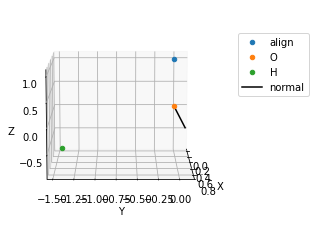

In [20]:
# Setup 3D plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
    
# Plot atom locations
ax.scatter(alignment_axis[0, 0].item(), alignment_axis[0, 1].item(), alignment_axis[0, 2].item(), label="align")
ax.scatter(solute_atom[0, 0].item(), solute_atom[0, 1].item(), solute_atom[0, 2].item(), label="O")
ax.scatter(atom_to_align[0, 0].item(), atom_to_align[0, 1].item(), atom_to_align[0, 2].item(), label="H")

ax.plot([0, normal_axis[0, 0].item()], [0, normal_axis[0, 1].item()], [0, normal_axis[0, 2].item()], label="normal", c="k")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.legend(bbox_to_anchor=(1.4, 0.9))

ax.view_init(10, 0)
plt.draw()

print(alignment_axis)
print(solute_atom)
print(atom_to_align)
print(normal_axis)
print(rotation_rad)

In [21]:
def rotation_matrix(rotation_axis, rotation_rad):
    # Euler-Rodrigues
    a = torch.cos(rotation_rad / 2)
    # orthogonal to both alignment and to-align atom.
    rot_axis = unit_vector(rotation_axis)
    # Why -rot_axis? Not on Wikipedia, but works (+ does not work, because it rotates in the wrong direction)
    xyz_rot = -rot_axis * torch.sin(rotation_rad / 2).unsqueeze(-1)
    b = xyz_rot[:, 0]
    c = xyz_rot[:, 1]
    d = xyz_rot[:, 2]
    
    rot_matrix = torch.stack([
        torch.stack([a * a + b * b - c * c - d * d, 2 * (b * c - a * d), 2 * (b * d + a * c)], dim=1),
        torch.stack([2 * (b * c + a * d), a * a + c * c - b * b - d * d, 2 * (c * d - a * b)], dim=1),
        torch.stack([2 * (b * d - a * c), 2 * (c * d + a * b), a * a + d * d - b * b - c * c], dim=1)
    ], dim=2)
    
    return rot_matrix

rot_matrix = rotation_matrix(normal_axis, rotation_rad)

In [22]:
x_rot_to_z = torch.einsum('bij,bnj -> bni', rot_matrix, x_ordered)
print(x_rot_to_z[0])

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 3.3528e-08, -4.7684e-07,  1.6794e+00],
        [-1.6110e-01, -9.6123e-01,  5.0561e-01],
        [-1.0209e+00,  3.6066e-01, -2.6083e-01],
        [-2.5069e+00, -1.0483e+00,  8.9498e-01],
        [ 6.4253e-01,  2.1307e-01,  1.5060e+00],
        [ 2.2741e-01,  9.4487e-01,  1.4951e+00],
        [-1.2230e+00,  9.9300e-02,  1.6218e-01],
        [ 7.0139e-01,  1.1940e+00,  1.2436e-01]])


In [23]:
# Sanity checks
x_rot_norm = x_rot_to_z / torch.norm(x_rot_to_z, dim=2, keepdim=True)
# to-align atom z value has to be 1
if not torch.isclose(x_rot_norm[:, 1, 2], torch.ones(1)).all():
    raise ValueError("z-coordinate not aligned.")
# to-align atom xy values have to be 0
if not torch.isclose(x_rot_norm[:, 1, 0:2], torch.zeros(1), atol=1e-5).all():
    raise ValueError("x- or y-coordinate not aligned.")

### Now: put the whole first-3-atom-system in the yz-plane (orthogonal to the x-axis). This ensures that we get consistent representations between X and Z when going back-and-forth.

In [24]:
# This means we align the second H atom with the x = 0 plane.
# We want to rotate around the z-axis, so that the first H atom stays fixed in place.
# So to find the angle, we project the second H atom onto the xy-plane, and then project onto the y-axis.

# Define plane by normal
plane_normal = x_rot_to_z.new_zeros(x_rot_to_z.shape[0], 3)
plane_normal[:, 0] = 1
# Atom (e.g., second H atom) to align: n_batch x 3
atom_to_align = x_rot_to_z[:, 2, :]

# To project an atom onto a plane, we in general project the atom onto the plane normal, 
#  then subtract this component form the original to find the projection onto the plane.
# However, we have an easy solution: projecting onto the xy-plane is just setting the z-component to 0.
# Similarly, projecting on the y-axis is then setting the x-component to 0.
# Here we use the plane projection, because it means we don't have to mutate an existing object.
plane_normal = alignment_axis  # z-axis
xy_proj = atom_to_align - unit_vector(plane_normal) * torch.sum(plane_normal * atom_to_align, dim=1, keepdim=True)

y_axis = x_rot_to_z.new_zeros(x_rot_to_z.shape[0], 3)
y_axis[:, 1] = 1

# Angle between atom_to_align and projection, through origin (solute_atom)
rotation_rad, _ = get_angle_and_normal(y_axis, solute_atom, xy_proj, to_yz_plane=True)

# We rotate around the alignment axis (z-axis) to put the molecule into the yz-plane
rot_matrix = rotation_matrix(plane_normal, rotation_rad)

# x rotated into the yz plane
x_rot = torch.einsum('bij,bnj -> bni', rot_matrix, x_rot_to_z)

print(x_rot[:, :3, :])

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.1189e-07,  4.6474e-07,  1.6794e+00],
         [-2.8312e-07,  9.7464e-01,  5.0561e-01]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 4.0280e-08,  4.3934e-08,  1.0900e+00],
         [-7.1526e-07,  2.2562e+00,  2.4900e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 5.3951e-08, -2.9394e-08,  1.4927e+00],
         [-5.9605e-08,  1.1295e+00,  2.4483e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.1196e-07,  4.0981e-08,  6.6838e-01],
         [ 0.0000e+00,  2.4416e+00,  1.0535e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 2.3259e-07,  9.0415e-09,  1.9162e+00],
         [ 5.9605e-08,  1.0842e+00,  8.3836e-01]]])


### Now: ordering based on angle

Note: this means we need a fixed orientation, otherwise we don't know which way to rotate when reconstructing Z --> X from angle information. We choose the convention (see `get_angle_and_normal()`) that the rotation axis has x > 0: i.e., we rotate anti-clockwise.

In [25]:
# Now we can start permuting the remaining atoms (e.g., hydrogens) within the molecules, if necessary.
rem_inds = []  # indices of remaining atoms to order (e.g., H atoms of solvent molecules)
for atom_num in range(x_rot.shape[1]):
    if atom_num < atoms_per_solute_mol:  # Skip solute atoms
        continue
    elif (atom_num - atoms_per_solute_mol) % atoms_per_solvent_mol == 0: # Skip reference atoms
        continue
    rem_inds.append(atom_num)

rem_inds

[4, 5, 7, 8]

In [26]:
# Build full permutation matrix, and fill in fixed sites (solute atoms + reference atoms)
full_permute = torch.zeros(x_rot.shape[:2])
for atom_num in range(x_rot.shape[1]):
    if atom_num not in rem_inds:
        full_permute[:, atom_num] = atom_num
full_permute = full_permute.long()
        
full_permute, full_permute.shape

(tensor([[0, 1, 2, 3, 0, 0, 6, 0, 0],
         [0, 1, 2, 3, 0, 0, 6, 0, 0],
         [0, 1, 2, 3, 0, 0, 6, 0, 0],
         [0, 1, 2, 3, 0, 0, 6, 0, 0],
         [0, 1, 2, 3, 0, 0, 6, 0, 0]]),
 torch.Size([5, 9]))

In [27]:
# Loop over blocks (molecules)

b = x_rot.shape[0]
n = x_rot.shape[1]
nblock = atoms_per_solvent_mol - 1

for block_num in range((n - atoms_per_solute_mol) // atoms_per_solvent_mol):
    # Remaining atom inds for this block
    inds_of_block = [
        atoms_per_solute_mol + block_num * atoms_per_solvent_mol + i 
        for i in range(1, atoms_per_solvent_mol)
    ]

    # n_batch x num_remaining_atoms_in_block x 3: for water this is n_batch x 2 x 3
    block_coords = x_rot[:, inds_of_block, :]  
    
    # Batched over samples (n_batch), but not over molecules within a block yet.
    # Batch this by reshaping to n_batch . num_remaining_atoms_in_block x 3 and then reshaping back.
    batched_molecule = block_coords.reshape(b * nblock, 3)
    # Alignment axis and solute atom have fixed coordinates, so we can simply expand for batching.
    batched_alignment_axis = alignment_axis.repeat(nblock, 1) 
    batched_solute_atom = solute_atom.repeat(nblock, 1) 
    # Get angles in batched fashion
    # Note: These rotations are around different normals depending on the position, but the angle
    #  with the z-axis should be independent of this.
    batched_rotation_rad, _ = get_angle_and_normal(
        batched_alignment_axis, batched_solute_atom, batched_molecule
    )    
    # n_batch x num_remaining_atoms_in_block
    rotation_rads = batched_rotation_rad.reshape(b, nblock)  
    
    # Checked that this gives same result as doing this loop:
    #  for atom_num in range(block_coords.shape[1]):
    #     rotation_rad, _ = get_angle_and_normal(alignment_axis, solute_atom, block_coords[:, atom_num, :])
    #     print(rotation_rad)

    batch_inds_of_block = torch.tensor(inds_of_block).repeat(b, 1)
    batch_permutation = torch.argsort(rotation_rads, dim=1)

    flat_permutation = (
        batch_permutation + (torch.arange(0, b) * nblock).unsqueeze(-1)
    ).flatten().long()
    
    permuted_inds_of_block = batch_inds_of_block.flatten()[flat_permutation].reshape(b, nblock)
    full_permute[:, inds_of_block] = permuted_inds_of_block

full_permute

tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8],
        [0, 1, 2, 3, 5, 4, 6, 7, 8],
        [0, 1, 2, 3, 5, 4, 6, 8, 7],
        [0, 1, 2, 3, 4, 5, 6, 7, 8],
        [0, 1, 2, 3, 5, 4, 6, 7, 8]])

In [28]:
# Do permutation of remaining atoms
flat_permute = (full_permute + (torch.arange(0, b) * n).unsqueeze(1)).flatten().unsqueeze(-1).long()
x_rem_ordered = x_rot.reshape(b * n, 3)[flat_permute].reshape(b, n, 3)
full_permute[0], x_rot[0], x_rem_ordered[0]

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.1189e-07,  4.6474e-07,  1.6794e+00],
         [-2.8312e-07,  9.7464e-01,  5.0561e-01],
         [ 1.0665e+00, -1.8695e-01, -2.6083e-01],
         [ 2.2992e+00,  1.4483e+00,  8.9498e-01],
         [-5.9847e-01, -3.1635e-01,  1.5060e+00],
         [-6.8096e-02, -9.6946e-01,  1.4951e+00],
         [ 1.2226e+00,  1.0423e-01,  1.6218e-01],
         [-4.9437e-01, -1.2935e+00,  1.2436e-01]]),
 tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.1189e-07,  4.6474e-07,  1.6794e+00],
         [-2.8312e-07,  9.7464e-01,  5.0561e-01],
         [ 1.0665e+00, -1.8695e-01, -2.6083e-01],
         [ 2.2992e+00,  1.4483e+00,  8.9498e-01],
         [-5.9847e-01, -3.1635e-01,  1.5060e+00],
         [-6.8096e-02, -9.6946e-01,  1.4951e+00],
         [ 1.2226e+00,  1.0423e-01,  1.6218e-01],
         [-4.9437e-01, -1.2935e+00,  1.2436e-01]]))

In [29]:
# Clone because perm_parity sorts in place.
remaining_parities = torch.tensor([perm_parity(perm) for perm in full_permute.clone()])
parities = reference_parities * remaining_parities
parities

tensor([-1,  1,  1,  1,  1])

### Done with ordering and setting up references. Now actually compute the rest of the z-matrix.

In [30]:
x_rem_ordered[0]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.1189e-07,  4.6474e-07,  1.6794e+00],
        [-2.8312e-07,  9.7464e-01,  5.0561e-01],
        [ 1.0665e+00, -1.8695e-01, -2.6083e-01],
        [ 2.2992e+00,  1.4483e+00,  8.9498e-01],
        [-5.9847e-01, -3.1635e-01,  1.5060e+00],
        [-6.8096e-02, -9.6946e-01,  1.4951e+00],
        [ 1.2226e+00,  1.0423e-01,  1.6218e-01],
        [-4.9437e-01, -1.2935e+00,  1.2436e-01]])

In [31]:
def get_dihedral(atom1, atom2, atom3, atom4):
    """Returns the dihedral between four atoms in radian."""

    # TODO: Check that there are no issues with orientation and/or angle definition.
        
    b0 = atom1 - atom2  # intentionally different from the rest
    b1 = atom3 - atom2
    b2 = atom4 - atom3

    # normalize b1 so that it does not influence magnitude of vector
    # rejections that come next
    b1 = b1 / torch.norm(b1, dim=-1, keepdim=True)

    # vector rejections
    # v = projection of b0 onto plane perpendicular to b1
    #   = b0 minus component that aligns with b1
    # w = projection of b2 onto plane perpendicular to b1
    #   = b2 minus component that aligns with b1
    v = b0 - torch.sum(b0 * b1, dim=-1, keepdim=True) * b1
    w = b2 - torch.sum(b2 * b1, dim=-1, keepdim=True) * b1

    # angle between v and w in a plane is the torsion angle
    # v and w may not be normalized but that's fine since tan is y/x
    x = torch.sum(v * w, dim=-1)
    
    # TODO: Enforce a consistent orientation on the dihedral angle. Since we use the solute molecule
    #  as an anchor: angle between O-H-H and H-H-current_atom, we can choose this as the rotation around
    #  the H-H vector. The remaining choice is H1-H2 or H2-H1. Since b1 is defined as H2-H1 already, we
    #  can just use this convention.
    # TODO: Both b1 and v lie in the yz-plane (because the solute molecule does). This means that 
    #  b1xv is aligned with the x-axis. Do we need to choose a convention here? We can choose the 
    #  convention that x > 0 for the rotation axis, but I'm not sure how this would actually work.
    #  Maybe sign on b1xv? But this is not the rotation axis; that's b1.
    b1xv = torch.cross(b1, v)
    
    sign = torch.sign(b1xv[:, 0])  # x > 0 convention
    b1xv = sign.unsqueeze(-1) * b1xv
    
    y = torch.sum(b1xv * w, dim=-1)
    rads = torch.arctan(y / x)
    
    # Adjust angles:
    #  This evaluates to: 2pi - rads if sign = -1, else: 0 + rads
    rads = 2 * math.pi * (1 - sign) / 2 + sign * rads
    return rads

In [32]:
# Compute z_matrix in batches, per atom.
x = x_rem_ordered

print(x[0])

z = x.new_zeros(x.shape)

for atom_num in range(x.shape[1]): 
    atom_coords = x[:, atom_num, :]
    
    if atom_num == 0:  # solute reference: [0, 0, 0] in z
        if not torch.isclose(torch.zeros(x.shape[0], 3), atom_coords).all():
            raise ValueError(
                "Expected first atom to be at origin, but norm mismatch (n_batch): {}".format(
                    torch.norm(torch.zeros(x.shape[0], 3) - atom_coords, dim=1)
                )
            )
    elif atom_num == 1:  # axis-aligned atom [r, 0, 0]
        r = torch.norm(atom_coords, dim=-1)  # Vector norm
        # This should match the distance along z axis, since the the vector should be aligned with z-axis.
        if not torch.isclose(r, atom_coords[:, -1]).all():
            raise ValueError(
                "Expected atom to be aligned with z-axis, but norm mismatch (n_batch): {}".format(
                    torch.abs(r - torch.norm(atom_coords, dim=1))
                )
            )
        if not torch.isclose(unit_vector(alignment_axis), unit_vector(atom_coords), atol=1e-6).all():
            raise ValueError(
                "Expected atom to be aligned with z-axis, but vector mismatch (n_batch): {}".format(
                    torch.abs(unit_vector(alignment_axis) - unit_vector(atom_coords))
                )
            )
        z[:, atom_num, 0] = r
    elif atom_num == 2:  # distance and angle
        r = torch.norm(atom_coords, dim=-1)   
        rads, _ = get_angle_and_normal(alignment_axis, solute_atom, atom_coords)
        z[:, atom_num, 0] = r
        z[:, atom_num, 1] = rads
    else:  # distance, angle, dihedral
        r = torch.norm(atom_coords, dim=-1)   
        rads, _ = get_angle_and_normal(alignment_axis, solute_atom, atom_coords)
        solute_atom0 = x[:, 0, :]
        solute_atom1 = x[:, 1, :]
        solute_atom2 = x[:, 2, :]  # TODO: make this a dummy if it does not define a plane
        # TODO: Check that dihedrals are correct (orientation consistency?)
        dih = get_dihedral(solute_atom0, solute_atom1, solute_atom2, atom_coords)
        z[:, atom_num, 0] = r
        z[:, atom_num, 1] = rads
        z[:, atom_num, 2] = dih

# TODO: r**2 = 0 for solute oxygen and sin(phi) = 0 for solute oxygen and first hydrogen. This gives zero det...
#  How to handle this?
# logjacdet = torch.sum(torch.log(z[:, :, 0]**2 * torch.sin(zz[:, :, 1])), dim=1)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.1189e-07,  4.6474e-07,  1.6794e+00],
        [-2.8312e-07,  9.7464e-01,  5.0561e-01],
        [ 1.0665e+00, -1.8695e-01, -2.6083e-01],
        [ 2.2992e+00,  1.4483e+00,  8.9498e-01],
        [-5.9847e-01, -3.1635e-01,  1.5060e+00],
        [-6.8096e-02, -9.6946e-01,  1.4951e+00],
        [ 1.2226e+00,  1.0423e-01,  1.6218e-01],
        [-4.9437e-01, -1.2935e+00,  1.2436e-01]])


In [33]:
print(z[0])

tensor([[0.0000, 0.0000, 0.0000],
        [1.6794, 0.0000, 0.0000],
        [1.0980, 1.0922, 0.0000],
        [1.1137, 4.4760, 5.6264],
        [2.8609, 1.2526, 7.5934],
        [1.6511, 5.8608, 7.3197],
        [1.7832, 5.7068, 6.3619],
        [1.2377, 1.4394, 5.3411],
        [1.3903, 4.8020, 6.5269]])


## Now from z back to x!

### First order by O by distance

In [34]:
# How to ensure that O is at origin, first H is at [r, 0, 0], and second H is at [r, phi, 0]?
# Could just have the Flow predict n - 1 atoms, where we also replace
#  the z[:, 0, 1], z[:, 0, 2] and z[:, 1, 2] elements with 0. This means no gradients for these items,
#  which makes sense, because it's a fixed representational choice. When going X --> Z these values will
#  also be set to 0 by the transformation choices. Even when training on MD, the flow will not spend effort learning
#  this, as we will simply be setting outputs that need to match to 0, to 0.
# NOTE: This still doesn't solve the issue with the jacobian from X --> Z, as those transforms still happen.

In [35]:
# We assume z = n_batch x n_atoms x 3, although in practice this can be one fewer atom as well, 
#  since we set the first atom to the origin regardless.

# # NOTE: What happens to the jacobian for that atom?
# z = torch.randn(batch_size, num_atoms, dims)
# # Force all values to be positive (this can be done in architecture for actual NN)
# z = z * torch.sign(z)

# Setting reference frame
# mask = z.new_ones(z.shape)
# mask[:, 0, :] = 0
# mask[:, 1, 1:] = 0
# mask[:, 2, 2] = 0
# z = mask * z

# Now do the ordering of reference atoms
# Order reference atoms by r
ref_rs = z[:, atoms_per_solute_mol::atoms_per_solvent_mol, 0]
ref_permute = torch.argsort(ref_rs, dim=1) * atoms_per_solvent_mol

# Start building full permutation tensor.
#  First step is to permute reference atoms (e.g., oxygens) together with their hydrogens.
#  Then we can start permuting the remaining atoms (e.g., hydrogens) within the molecules, if necessary.
full_permute = torch.zeros(z.shape[:2])

# Solute molecule is fixed; reflect this in permutation tensor.
num_hydrogen = atoms_per_solvent_mol - 1
for j in range(1, num_hydrogen + 1, 1):
    full_permute[:, j] = j
    
# Inefficient way to build full permutation tensor
for full_perm, ref_perm in zip(full_permute, ref_permute):
    for i, ref_num in enumerate(ref_perm):
        # ref_permute skips solute molecule, so index this back in
        ind = atoms_per_solute_mol + i * atoms_per_solvent_mol  # index in permutation tensor
        atom_num = atoms_per_solute_mol + ref_num  # atom number that should be at this index
        full_perm[ind] = atom_num
        for j in range(1, num_hydrogen + 1, 1):
            full_perm[ind + j] = atom_num + j
            
full_permute   

tensor([[0., 1., 2., 3., 4., 5., 6., 7., 8.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8.]])

In [36]:
# Flatten along the batch and atoms dimension to do efficient permutation, rather than a for loop per row.
b = z.shape[0]
n = z.shape[1]
flat_z = z.reshape(b * n, -1)
flat_permute = (full_permute + (torch.arange(0, b) * n).unsqueeze(-1)).flatten().unsqueeze(-1).long()

z_ordered = flat_z[flat_permute].reshape(b, n, flat_z.shape[-1])

In [37]:
# Clone because perm_parity sorts in place.
reference_parities = torch.tensor([perm_parity(perm) for perm in full_permute.clone()])
reference_parities

tensor([1, 1, 1, 1, 1])

In [38]:
z[0], z_ordered[0]

(tensor([[0.0000, 0.0000, 0.0000],
         [1.6794, 0.0000, 0.0000],
         [1.0980, 1.0922, 0.0000],
         [1.1137, 4.4760, 5.6264],
         [2.8609, 1.2526, 7.5934],
         [1.6511, 5.8608, 7.3197],
         [1.7832, 5.7068, 6.3619],
         [1.2377, 1.4394, 5.3411],
         [1.3903, 4.8020, 6.5269]]),
 tensor([[0.0000, 0.0000, 0.0000],
         [1.6794, 0.0000, 0.0000],
         [1.0980, 1.0922, 0.0000],
         [1.1137, 4.4760, 5.6264],
         [2.8609, 1.2526, 7.5934],
         [1.6511, 5.8608, 7.3197],
         [1.7832, 5.7068, 6.3619],
         [1.2377, 1.4394, 5.3411],
         [1.3903, 4.8020, 6.5269]]))

### Order H by angle

In [39]:
# Now order the H atoms by angle phi

# Now we can start permuting the remaining atoms (e.g., hydrogens) within the molecules, if necessary.
rem_inds = []  # indices of remaining atoms to order (e.g., H atoms of solvent molecules)
for atom_num in range(z_ordered.shape[1]):
    if atom_num < atoms_per_solute_mol:  # Skip solute atoms
        continue
    elif (atom_num - atoms_per_solute_mol) % atoms_per_solvent_mol == 0: # Skip reference atoms
        continue
    rem_inds.append(atom_num)
    
# Build full permutation matrix, and fill in fixed sites (solute atoms + reference atoms)
full_permute = torch.zeros(z_ordered.shape[:2])
for atom_num in range(z_ordered.shape[1]):
    if atom_num not in rem_inds:
        full_permute[:, atom_num] = atom_num
full_permute = full_permute.long()

# Loop over blocks (molecules)
b = z_ordered.shape[0]
n = z_ordered.shape[1]
nblock = atoms_per_solvent_mol - 1

for block_num in range((n - atoms_per_solute_mol) // atoms_per_solvent_mol):
    # Remaining atom inds for this block
    inds_of_block = [
        atoms_per_solute_mol + block_num * atoms_per_solvent_mol + i 
        for i in range(1, atoms_per_solvent_mol)
    ]

    # n_batch x num_remaining_atoms_in_block: for water this is n_batch x 2
    block_phi = z_ordered[:, inds_of_block, 2]  
    # We want to sort the blocks in all batches simultaneously. So we construct a tensor
    #  representing the block indices for each batch. We now want to sort these by angle
    #  phi, so we argsort phi to find how the blcok indices should be permuted. To permute
    #  in vectorised fashion, we need to flatten along the batch dimension first.
    batch_inds_of_block = torch.tensor(inds_of_block).repeat(b, 1)
    batch_block_permutation = torch.argsort(block_phi, dim=1)
    # Create permutation array that will operate on the flattened version of
    # `batch_inds_of_block`. This will yield the correct permutation indices after reshaping.
    flat_permutation = (
        batch_block_permutation + (torch.arange(0, b) * nblock).unsqueeze(-1)
    ).flatten().long()
    # Correctly shaped permutation indices
    permuted_inds_of_block = batch_inds_of_block.flatten()[flat_permutation].reshape(b, nblock)
    # Fill in in full permutation index tensor
    full_permute[:, inds_of_block] = permuted_inds_of_block

# Do permutation of remaining atoms
# Same trick: flatten so we can do batched permutation
flat_permute = (full_permute + (torch.arange(0, b) * n).unsqueeze(1)).flatten().unsqueeze(-1).long()
z_rem_ordered = z_ordered.reshape(b * n, 3)[flat_permute].reshape(b, n, 3)
full_permute[0], z_rem_ordered[0], z_ordered[0]

(tensor([0, 1, 2, 3, 5, 4, 6, 7, 8]),
 tensor([[0.0000, 0.0000, 0.0000],
         [1.6794, 0.0000, 0.0000],
         [1.0980, 1.0922, 0.0000],
         [1.1137, 4.4760, 5.6264],
         [1.6511, 5.8608, 7.3197],
         [2.8609, 1.2526, 7.5934],
         [1.7832, 5.7068, 6.3619],
         [1.2377, 1.4394, 5.3411],
         [1.3903, 4.8020, 6.5269]]),
 tensor([[0.0000, 0.0000, 0.0000],
         [1.6794, 0.0000, 0.0000],
         [1.0980, 1.0922, 0.0000],
         [1.1137, 4.4760, 5.6264],
         [2.8609, 1.2526, 7.5934],
         [1.6511, 5.8608, 7.3197],
         [1.7832, 5.7068, 6.3619],
         [1.2377, 1.4394, 5.3411],
         [1.3903, 4.8020, 6.5269]]))

In [40]:
# Clone because perm_parity sorts in place.
remaining_parities = torch.tensor([perm_parity(perm) for perm in full_permute.clone()])
parities = reference_parities * remaining_parities
parities

tensor([ 1, -1,  1, -1, -1])

### Z is ordered, so now reconstruct X

In [42]:
x = z.new_zeros(z.shape)

for atom_num in range(z.shape[1]): 
    atom_coords = z[:, atom_num, :]    
    
    if atom_num == 0:  # solute reference: [0, 0, 0] in x
        if not torch.isclose(torch.zeros(z.shape[0], 3), atom_coords).all():
            raise ValueError(
                "Expected first atom to be at origin, but norm mismatch (n_batch): {}".format(
                    torch.norm(torch.zeros(z.shape[0], 3) - atom_coords, dim=1)
                )
            )
        continue
    elif atom_num == 1:  # axis-aligned atom: e.g., [0, 0, r] in x
        # phi and dihedral should be 0 for this atom
        if not torch.isclose(torch.zeros(z.shape[0], 2), atom_coords[:, 1:]).all():
            raise ValueError(
                "Expected first atom to be axis aligned, but norm mismatch (n_batch): {}".format(
                    torch.norm(torch.zeros(z.shape[0], 2) - atom_coords[:, 1:], dim=1)
                )
            )
        r = atom_coords[:, 0]
        x[:, atom_num, 2] = r
    elif atom_num == 2:  # distance and angle: reconstruct x
        # dihedral should be 0 for this atom
        if not torch.isclose(torch.zeros(z.shape[0], 1), atom_coords[:, 2:]).all():
            raise ValueError(
                "Expected third atom to have 0 dihedral, but norm mismatch (n_batch): {}".format(
                    torch.norm(torch.zeros(z.shape[0], 1) - atom_coords[:, 2:], dim=1)
                )
            )
        
        atom1 = x[:, 0, :]  # atom1 in x
        atom2 = x[:, 1, :]  # atom2 in x
        r = atom_coords[:, 0]  # atom-to-reconstruct r 
        rads = atom_coords[:, 1]  # atom-to-reconstruct phi
        # Note: atom1 = origin usually, so this is just unit_vector(atom2) = alignment axis.
        d = unit_vector(atom2 - atom1) * r.unsqueeze(-1)  # vector-to-rotate for reconstruction
        # Define normal for rotation: for X --> Z we took the x > 0 normal when rotating towards the
        #  alignment axis. Now we rotate away from the axis, so we take the negative angle.
        #  Alternatively, we can take the positive angle and the normal with x < 0.
        # NOTE: We checked that this gives the inverse of the original ordered x!
        normal = torch.zeros(r.shape[0], 3)
        normal[:, 0] = 1  # x-axis is normal
        rot_matrix = rotation_matrix(normal, -rads)
        # Apply rotation
        xyz = torch.einsum('bij,bj -> bi', rot_matrix, d)
        x[:, atom_num, :] = xyz
    else:
        # We always use the first molecule as the anchor for the angles.
        atom1 = x[:, 0, :]  # atom1 in x; e.g., solute O
        atom2 = x[:, 1, :]  # atom2 in x; e.g., first solute H
        atom3 = x[:, 2, :]  # atom3 in x; e.g., second solute H
        r = atom_coords[:, 0]  # atom-to-reconstruct r 
        rads = atom_coords[:, 1]  # atom-to-reconstruct phi
        dih = atom_coords[:, 2]  # atom-to-reconstruct dihedral
        
        # TODO: full reconstruction with dihedral
        # Step 1: create a vector of length r aligned with the z-axis (H1-O)
        xyz = unit_vector(atom2 - atom1) * r.unsqueeze(-1)
        # Step 2: rotate this vector around the positive x-axis (by convention) by -phi
        normal = torch.zeros(r.shape[0], 3)
        normal[:, 0] = 1  # x-axis is normal
        rot_matrix = rotation_matrix(normal, -rads)
        xyz = torch.einsum('bij,bj -> bi', rot_matrix, xyz)
        # Step 3: rotate this vector around the positive z-axis (by convention) by -dih
        normal = torch.zeros(r.shape[0], 3)
        normal[:, 2] = 1  # z-axis is normal
#         # Step 3: rotate this vector around the H2-H1 axis (by convention) by -dih
#         normal = unit_vector(atom3 - atom1)  # This gives wrong z-axis values
        rot_matrix = rotation_matrix(normal, -dih)
        xyz = torch.einsum('bij,bj -> bi', rot_matrix, xyz) 
        x[:, atom_num, :] = xyz
        # TODO: Check that this is the same as the original x.
        
x[0]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.6794],
        [ 0.0000,  0.9746,  0.5056],
        [ 0.6611, -0.8575, -0.2608],
        [ 2.6255,  0.7002,  0.8950],
        [-0.5826, -0.3447,  1.5060],
        [-0.0764, -0.9688,  1.4951],
        [-0.9924,  0.7216,  0.1622],
        [-0.3341, -1.3439,  0.1244]])

In [43]:
x_rem_ordered[0]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.1189e-07,  4.6474e-07,  1.6794e+00],
        [-2.8312e-07,  9.7464e-01,  5.0561e-01],
        [ 1.0665e+00, -1.8695e-01, -2.6083e-01],
        [ 2.2992e+00,  1.4483e+00,  8.9498e-01],
        [-5.9847e-01, -3.1635e-01,  1.5060e+00],
        [-6.8096e-02, -9.6946e-01,  1.4951e+00],
        [ 1.2226e+00,  1.0423e-01,  1.6218e-01],
        [-4.9437e-01, -1.2935e+00,  1.2436e-01]])

# TODO: 
Currently z-axis is correct on reconstruction, which means the phi rotation is correct, as expected.
The dihedral is still going wrong: set convention that x > 0 is the rotation axis?